### Assignment 7 - Detect computer security breach using RNNs and LSTMs
#### Natalie Kim

### Part A: Recurrent Neural Network & Classification
The objective is to detect the security breach by predicting suspicious access using an RNN model and the provided Logfile data.

Logfile data includes login information like LogID, Timestamp, Method, Path, Status Code, Source, Remote Address, User Agent, etc. THE last incdicator in each row denotes breach(1) and no breach(0) which is the target variable.

#### 1. Data Processing: 
This data set is a bit messy, so the preprocessing portion is largely a tutorial to make sure students have data ready for keras.
##### a) Import the following libraries:

In [1]:
import sys
import os
import json
import pandas as pd
import numpy
import optparse
import tensorflow

In [2]:
from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.layers import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import OrderedDict

##### b) Read code

In [3]:
filepath = "/Users/nataliekim/Library/CloudStorage/OneDrive-TheUniversityofChicago/machine learning/ml data/dev-access.csv"
dataframe = pd.read_csv(filepath, engine = 'python', quotechar = '|', header=None)

##### c) Convert to numpy.ndarray type:

In [4]:
dataset = dataframe.values

##### d) Check shape of the data set

In [5]:
print(f'dimensions: ({dataset.shape})')

dimensions: ((26773, 2))


In [6]:
#dataset[:5,:]

##### e) Store all rows and the 0th index as the feature data:

In [7]:
X = dataset[:,0]

##### f) Store all rows and index 1 as the target variable

In [8]:
Y = dataset[:,1]

##### g) Clean up predictors. Remove features that are not valuable, such as timestamp and source

In [9]:
for index, item in enumerate(X):
    # Quick hack to space out json elements
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    X[index] = json.dumps(reqJson, separators=(',', ':'))

##### h) Tokenize data: Given the data, tokenize every character (thus char_level = True)

In [10]:
tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(X)

# we will need this later
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)

##### i) Need to pad our data as each observation has a different length

In [11]:
max_log_length = 1024
X_processed = sequence.pad_sequences(X, maxlen=max_log_length)

##### j) Create your train set to be 75% of the data and your test set to be 25%

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, Y, test_size = 0.25, random_state = 42)

#### 2. Model 1 - RNN
The first model will be a pretty minimal RNN with only an embedding layer, simple RNN and Dense layer. The next model we will add a few more layers. 

##### a) Start by creating an instance of a Sequential model

In [14]:
from tensorflow.keras.layers import Input

In [15]:
model = Sequential()
model.add(Input(shape=(max_log_length,)))

##### b) From there, add an Embedding layer

Params:
- input_dim = num_words (the variable we created above)
- output_dim = 32
- input_length = max_log_length (we also created this above)
- Keep all other variables as the defaults (shown below)

In [16]:
model.add(Embedding(input_dim = num_words, output_dim = 32))

##### c) Add a SimpleRNN layer

Params:
- units = 32
- activation = 'relu'

In [17]:
from keras.layers import SimpleRNN

In [18]:
model.add(SimpleRNN(units = 32, activation = 'relu'))

##### d) Finally, we will add a Dense layer

Params:
- units = 1 (this will be our output)
- activation --> you can choose to use either relu or sigmoid. 

In [19]:
model.add(Dense(units = 1, activation = 'sigmoid'))

In [20]:
model.layers

[<Embedding name=embedding, built=True>,
 <SimpleRNN name=simple_rnn, built=True>,
 <Dense name=dense, built=True>]

##### e) Compile model using the .compile() method

Params:
- loss = binary_crossentropy
- optimizer = adam
- metrics = accuracy

In [21]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

##### f) Print the model summary

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1024, 32)       │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,129 (16.13 KB)

 Trainable params: 4,129 (16.13 KB)

 Non-trainable params: 0 (0.00 B)

##### g) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [23]:
# convert to float32 format. currently as int type
X_train = numpy.array(X_train).astype('float32')
y_train = numpy.array(y_train).astype('float32')

In [24]:
model.fit(
    x=X_train,
    y=y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.25
)

Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.5739 - loss: 0.6629 - val_accuracy: 0.5239 - val_loss: 0.7987
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.5769 - loss: 0.6568 - val_accuracy: 0.6426 - val_loss: 0.5716
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.6802 - loss: 0.5427 - val_accuracy: 0.9124 - val_loss: 0.2777


##### h) Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [25]:
# convert to float32 format. currently as int type
X_test = numpy.array(X_test).astype('float32')
y_test = numpy.array(y_test).astype('float32')

In [26]:
test_loss1, test_accuracy1 = model.evaluate(X_test, y_test, batch_size=128)
print(f"Test Loss: {test_loss1}")
print(f"Test Accuracy: {test_accuracy1}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9157 - loss: 0.2632
Test Loss: 0.26856762170791626
Test Accuracy: 0.9127576947212219


#### 3. Model 2 - LSTM + Dropout Layers:
Now we will add a few new layers to our RNN and incorporate the more powerful LSTM. You will be creating a new model here, so make sure to call it something different than the model from Part 2.

##### a) This RNN needs to have the following layers (add in this order):

- Embedding Layer (use same params as before)
- LSTM Layer (units = 64, recurrent_dropout = 0.5)
- Dropout Layer - use a value of 0.5
- Dense Layer - (use same params as before)

In [27]:
model2 = Sequential(name="Model2")
model2.add(Input(shape=(max_log_length,)))

In [28]:
# Embedding Layer
model2.add(Embedding(input_dim = num_words, output_dim = 32))

In [29]:
# LSTM Layer
model2.add(LSTM(units = 64, recurrent_dropout = 0.5))

In [30]:
# Dropout Layer
model2.add(Dropout(0.5))

In [31]:
# Dense Layer
model2.add(Dense(units=1, activation='sigmoid'))

In [32]:
model2.layers

[<Embedding name=embedding_1, built=True>,
 <LSTM name=lstm, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

##### b) Compile model using the .compile() method:

Params:
- loss = binary_crossentropy
- optimizer = adam
- metrics = accuracy

In [33]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

##### c) Print the model summary

In [34]:
model2.summary()

Model: "Model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1024, 32)       │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,913 (105.13 KB)

 Trainable params: 26,913 (105.13 KB)

 Non-trainable params: 0 (0.00 B)

##### d) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [35]:
model2.fit(
    x=X_train,
    y=y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.25
)

Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 64s 536ms/step - accuracy: 0.6192 - loss: 0.6283 - val_accuracy: 0.9026 - val_loss: 0.2703
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 62s 523ms/step - accuracy: 0.8717 - loss: 0.3429 - val_accuracy: 0.9560 - val_loss: 0.1610
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 63s 538ms/step - accuracy: 0.9330 - loss: 0.2279 - val_accuracy: 0.9592 - val_loss: 0.1468


##### e) Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [36]:
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test, batch_size=128)
print(f"Test Loss: {test_loss2}")
print(f"Test Accuracy: {test_accuracy2}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.9547 - loss: 0.1619
Test Loss: 0.1566932201385498
Test Accuracy: 0.9572751522064209


#### 4) Recurrent Neural Net Model 3: Build Your Own
You wil now create your RNN based on what you have learned from Model 1 & Model 2

##### a) RNN Requirements:
- Use 5 or more layers
- Add a layer that was not utilized in Model 1 or Model 2 (Note: This could be a new Dense layer or an additional LSTM)

In [37]:
model3 = Sequential(name="Model3")
model3.add(Input(shape=(max_log_length,)))

In [38]:
# Embedding Layer
model3.add(Embedding(input_dim = num_words, output_dim = 32))

In [39]:
# LSTM Layer 1
model3.add(LSTM(units = 64, recurrent_dropout = 0.5, return_sequences=True))

In [40]:
# LSTM Layer 2
model3.add(LSTM(units=32, recurrent_dropout = 0.5, return_sequences=False))

In [41]:
# Dropout Layer
model3.add(Dropout(0.5))

In [42]:
# Dense Layer 1
model3.add(Dense(units=64, activation='relu'))

In [43]:
# Dense Layer 2
model3.add(Dense(units=1, activation='sigmoid'))

In [44]:
model3.layers

[<Embedding name=embedding_2, built=True>,
 <LSTM name=lstm_1, built=True>,
 <LSTM name=lstm_2, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>]

##### b) Compiler Requirements:
- Try a new optimizer for the compile step
- Keep accuracy as a metric (feel free to add more metrics if desired)

In [45]:
model3.compile(
    optimizer='nadam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

##### c) Print the model summary

In [46]:
model3.summary()

Model: "Model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 1024, 32)       │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1024, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,441 (161.88 KB)

 Trainable params: 41,441 (161.88 KB)

 Non-trainable params: 0 (0.00 B)

##### d) Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

In [47]:
model3.fit(
    x=X_train,
    y=y_train,
    epochs=3,
    batch_size=128,
    validation_split=0.25
)

Epoch 1/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 110s 922ms/step - accuracy: 0.6508 - loss: 0.5839 - val_accuracy: 0.9639 - val_loss: 0.1204
Epoch 2/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 103s 877ms/step - accuracy: 0.9114 - loss: 0.2496 - val_accuracy: 0.9233 - val_loss: 0.2414
Epoch 3/3
118/118 ━━━━━━━━━━━━━━━━━━━━ 107s 909ms/step - accuracy: 0.9317 - loss: 0.2329 - val_accuracy: 0.9602 - val_loss: 0.1507


##### e) Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

In [48]:
test_loss3, test_accuracy3 = model3.evaluate(X_test, y_test, batch_size=128)
print(f"Test Loss: {test_loss3}")
print(f"Test Accuracy: {test_accuracy3}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - accuracy: 0.9571 - loss: 0.1622
Test Loss: 0.16200977563858032
Test Accuracy: 0.9572751522064209


#### Conceptual Questions: 

##### 5) Explain the difference between the relu activation function and the sigmoid activation function.
ReLU is primarily used for hidden layers whereas the sigmoid is used for the outer layer of binary classification models where a probability score is required. There is also a difference between the outputs. ReLU outputs the input if positive, and zero if otherwise. Sigmoid, on the other hand returns values between 0 and 1, making it mostly useful for models when we need to predict probabilities.

##### 6) Describe what one epoch actually is (epoch was a parameter used in the .fit() method).
An epoch is a complete pass of the training dataset through the the algorith, or the full traiing dataset, both forward and backward. Setting its value in the .fit() method tells the training process how many times we want to cycle through the data.

##### 7) Explain how dropout works (you can look at the keras code and/or documentation) for (a) training, and (b) test data sets.
(a) The Dropout layer of the RNN randomly sets input units to 0 with a frequency of rate at each step during training. This is to help prevent overfitting and prevent the unit from adapting too much by forcing the RNN to learn more robust features.

(b) In testing, dropout is disabled and the neuron's output values are scaled down by the dropout rate in order to account for the reduced active units from training.

##### 8) Explain why problems such as this homework assignment are better modeled with RNNs than CNNs. What type of problem will CNNs outperform RNNs on?
Since our homework assignment is logfile data - which includes login information LogID, Timestamp, Method, Path, Status Code, etc. - in which we are trying to detect a security breach by predicting suspicious access. Remembering the long-term dependencies and sequential nature of the logs are better fit for RNNs. This is because predicting a security breach will likely be more accurate seeing the order and history of the login data.

CNNs will outperform RNNs on problems about images such as classification and facial recognition, or local feature identification in which pattern recognition is more local and there is no need to capture temporal dynamics.

##### 9) Explain what RNN problem is solved using LSTM and briefly describe how.
The RNN problem that LSTM solves is the networks ability to learn due to gradients either vanishing or exploding. These extremes prevent the RNN from learning the dependencies between distant elements. It achieves this by using input, forget, and output gates to determine whether to let new input data in, delete information data, or let the impact the output at the current timestep, respectively.

### PART B: Time Series with LSTMs
Use the data DAYTON_hourly.csvDownload DAYTON_hourly.csv

##### Import, clean and plot the input data

In [49]:
import pandas as pd

In [50]:
data = pd.read_csv(r'/Users/nataliekim/Library/CloudStorage/OneDrive-TheUniversityofChicago/machine learning/ml data/DAYTON_hourly.csv')

In [51]:
data.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Datetime   121275 non-null  object 
 1   DAYTON_MW  121275 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [53]:
# Converting 'Datetime' to correct type
data.Datetime = pd.to_datetime(data.Datetime)
data.sort_values(by="Datetime", inplace=True)

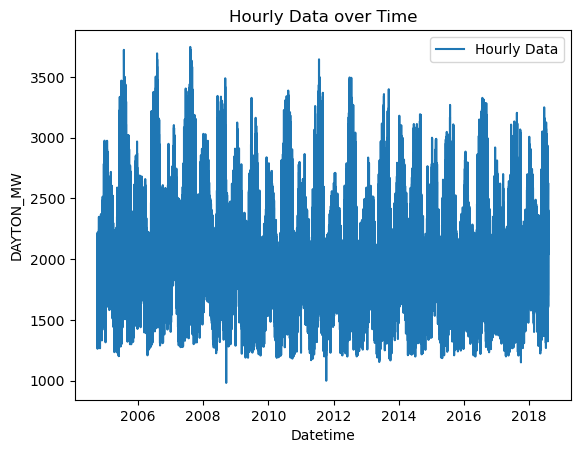

In [54]:
# Plotting data
import matplotlib.pyplot as plt

plt.plot(data['Datetime'], data['DAYTON_MW'], label='Hourly Data')
plt.title('Hourly Data over Time')
plt.xlabel('Datetime')
plt.ylabel('DAYTON_MW')
plt.legend()
plt.show()

##### Train test split (use provided helper function helper.py Download helper.py, as we can’t use sklearn’s for time series data)

In [55]:
from helper import *

In [57]:
lag = 3
test_ratio = 0.15
X_train, X_test, Y_train, Y_test = create_data_for_NN(
    data, data.columns[-1], lag, test_ratio
)

##### Fit a single layer LSTM with lag = 3 hours

In [56]:
from tensorflow.keras.layers import Bidirectional

In [90]:
model_3hr = Sequential([
    LSTM(units = 50, recurrent_dropout=0.5),
    Dense(1)
])

In [91]:
model_3hr.compile(
    optimizer='adam', 
    loss='mean_squared_error',
    metrics=['accuracy']
)

In [92]:
model_3hr.fit(
    X_train, 
    Y_train, 
    epochs=20, 
    validation_split=0.25
)

Epoch 1/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 2s 736us/step - accuracy: 0.0000e+00 - loss: 4354421.0000 - val_accuracy: 0.0000e+00 - val_loss: 3982657.2500
Epoch 2/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 2s 695us/step - accuracy: 0.0000e+00 - loss: 4234024.5000 - val_accuracy: 0.0000e+00 - val_loss: 3872469.0000
Epoch 3/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - accuracy: 0.0000e+00 - loss: 4119581.5000 - val_accuracy: 0.0000e+00 - val_loss: 3764050.2500
Epoch 4/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 2s 737us/step - accuracy: 0.0000e+00 - loss: 4009139.2500 - val_accuracy: 0.0000e+00 - val_loss: 3657209.5000
Epoch 5/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 2s 720us/step - accuracy: 0.0000e+00 - loss: 3904187.5000 - val_accuracy: 0.0000e+00 - val_loss: 3552007.5000
Epoch 6/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 2s 685us/step - accuracy: 0.0000e+00 - loss: 3796821.7500 - val_accuracy: 0.0000e+00 - val_loss: 3448356.7500
Epoch 7/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 2s 702us/step - accuracy: 0.0000e+00 - loss: 3

##### Fit a single layer LSTM with lag = 24 hours

In [96]:
lag = 24
X_train, X_test, Y_train, Y_test = create_data_for_NN(
    data, data.columns[-1], lag, test_ratio
)

In [97]:
model_24hr = Sequential([
    LSTM(units = 50),
    Dense(1)
])

In [98]:
model_24hr.compile(
    optimizer='adam', 
    loss='mean_squared_error',
    metrics=['accuracy']
)

In [99]:
model_24hr.fit(
    X_train, 
    Y_train, 
    epochs=20, 
    validation_split=0.25
)

Epoch 1/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0000e+00 - loss: 4351977.0000 - val_accuracy: 0.0000e+00 - val_loss: 3991022.5000
Epoch 2/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 4243461.5000 - val_accuracy: 0.0000e+00 - val_loss: 3887078.2500
Epoch 3/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 4142449.2500 - val_accuracy: 0.0000e+00 - val_loss: 3784643.2500
Epoch 4/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 4043431.5000 - val_accuracy: 0.0000e+00 - val_loss: 3683587.7500
Epoch 5/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 3927550.5000 - val_accuracy: 0.0000e+00 - val_loss: 3584004.7500
Epoch 6/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 3822117.0000 - val_accuracy: 0.0000e+00 - val_loss: 3485813.2500
Epoch 7/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 3720377.0000 - 

##### Fit a bidirectional LSTM with lag = 24 hours

In [100]:
model_bidir = Sequential([
    Bidirectional(LSTM(units=50)),
    Dense(1)
])

In [101]:
model_bidir.compile(
    optimizer='adam', 
    loss='mean_squared_error',
    metrics=['accuracy']
)

In [102]:
model_bidir.fit(
    X_train,
    Y_train,
    epochs=20,
    validation_split=0.25
)

Epoch 1/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0000e+00 - loss: 4311975.0000 - val_accuracy: 0.0000e+00 - val_loss: 3805317.2500
Epoch 2/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0000e+00 - loss: 3997485.2500 - val_accuracy: 0.0000e+00 - val_loss: 3515314.7500
Epoch 3/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.0000e+00 - loss: 3702049.0000 - val_accuracy: 0.0000e+00 - val_loss: 3242241.2500
Epoch 4/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0000e+00 - loss: 3427290.5000 - val_accuracy: 0.0000e+00 - val_loss: 2981229.5000
Epoch 5/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0000e+00 - loss: 3162978.7500 - val_accuracy: 0.0000e+00 - val_loss: 2731896.2500
Epoch 6/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.0000e+00 - loss: 2911950.2500 - val_accuracy: 0.0000e+00 - val_loss: 2494231.0000
Epoch 7/20
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.0000e+00 - loss: 2656580.

##### Plot results on test set and compare performance using RMSE

In [68]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [93]:
# LSTM, lag 3
predictions_3hr = model_3hr.predict(X_test)
rmse_3hr = sqrt(mean_squared_error(Y_test, predictions_3hr))

569/569 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step


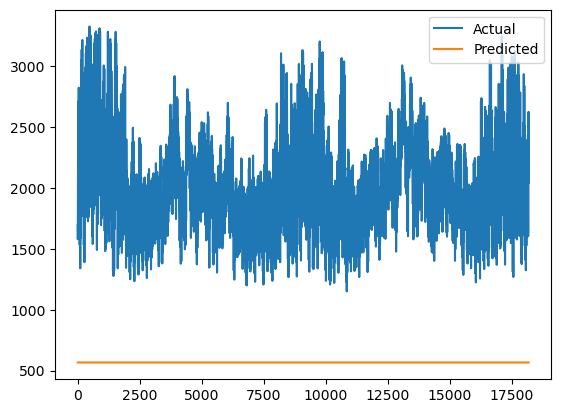

In [95]:
plt.plot(Y_test, label='Actual')
plt.plot(predictions_3hr, label='Predicted')
plt.legend()

In [103]:
# LSTM, lag 24
predictions_24hr = model_24hr.predict(X_test)
rmse_24hr = sqrt(mean_squared_error(Y_test, predictions_24hr))

569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step


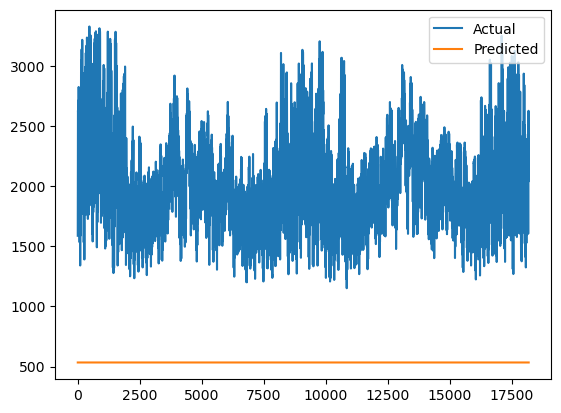

In [104]:
plt.plot(Y_test, label='Actual')
plt.plot(predictions_24hr, label='Predicted')
plt.legend()

In [105]:
# Bidirectional LSTM, lag 24
predictions_bidir = model_bidir.predict(X_test)
rmse_bidir = sqrt(mean_squared_error(Y_test, predictions_bidir))

569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


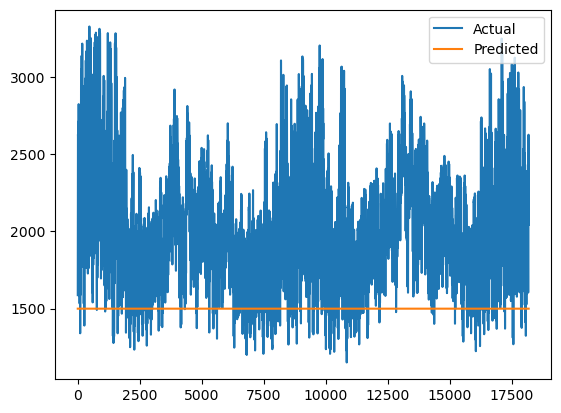

In [106]:
plt.plot(Y_test, label='Actual')
plt.plot(predictions_bidir, label='Predicted')
plt.legend()

In [107]:
print('RMSE with 3hr lag:', rmse_3hr)
print('RMSE with 24hr lag:', rmse_24hr)
print('RMSE with Bidirectional LSTM and 24hr lag:', rmse_bidir)

RMSE with 3hr lag: 1512.1752153222264
RMSE with 24hr lag: 1543.9516228362882
RMSE with Bidirectional LSTM and 24hr lag: 655.0544611870569
